In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from datetime import datetime, timezone

In [135]:
from mpl_toolkits.mplot3d import Axes3D

In [182]:
from sklearn.cluster import KMeans

In [2]:
#Load files
path = 'archive/'
Oct19 = pd.read_csv(path + r'2019-Oct.csv')
Nov19 = pd.read_csv(path + r'2019-Nov.csv')
Dec19 = pd.read_csv(path + r'2019-Dec.csv')
Jan20 = pd.read_csv(path + r'2020-Jan.csv')
Feb20 = pd.read_csv(path + r'2020-Feb.csv')

## Data Preprocess

In [3]:
#Concat five month
All_data = pd.concat([Oct19, Nov19, Dec19, Jan20, Feb20], axis = 0)

In [4]:
All_data.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [196]:
All_data.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [197]:
All_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20692840 entries, 0 to 4156681
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.7+ GB


In [198]:
# Checking missing precentages
percent_missing = All_data.isnull().sum() * 100 / len(All_data)
missing_value_df = pd.DataFrame({'column_name': All_data.columns,
                                 'percent_missing': percent_missing})

In [199]:
missing_value_df

,column_name,percent_missing
event_time,event_time,0.000000
event_type,event_type,0.000000
product_id,product_id,0.000000
category_id,category_id,0.000000
category_code,category_code,98.291225
brand,brand,42.319551
price,price,0.000000
user_id,user_id,0.000000
user_session,user_session,0.022220


### Cleansing

In [5]:
target_data = All_data.drop(columns=['category_id','category_code','brand','product_id','user_session'])

In [6]:
target_data.head(3)

,event_time,event_type,price,user_id
0,2019-10-01 00:00:00 UTC,cart,2.62,463240011
1,2019-10-01 00:00:03 UTC,cart,2.62,463240011
2,2019-10-01 00:00:07 UTC,cart,13.48,429681830


In [17]:
#Checking nulls
for i in target_data.columns:
    print(i + ' has ' + str(target_data[i].isnull().sum()) + ' null.')

event_time has 0 null.
event_type has 0 null.
price has 0 null.
user_id has 0 null.


In [29]:
#Checking duplicates
# print(target_data.duplicated().sum())
# dup = target_data[target_data.duplicated()]
# dup.head(3)
#重複可能為一秒內連按兩次新增/移除，故不刪除（推測為有效動作）

1629333


,event_time,event_type,price,user_id
13,2019-10-01 00:00:30 UTC,remove_from_cart,0.60,429681830
30,2019-10-01 00:01:05 UTC,remove_from_cart,0.79,429681830
36,2019-10-01 00:01:07 UTC,remove_from_cart,1.27,467916806


### Feature Engineering 

In [94]:
target_data.head(3)

,event_time,event_type,price,user_id,month
0,2019-10-01 00:00:00,cart,2.62,463240011,2019-10
1,2019-10-01 00:00:03,cart,2.62,463240011,2019-10
2,2019-10-01 00:00:07,cart,13.48,429681830,2019-10


In [39]:
#Convert event_time to dt
target_data['event_time']=pd.to_datetime(target_data['event_time'],infer_datetime_format=True)
#Remove UTC stamp
target_data['event_time'] = target_data['event_time'].dt.tz_localize(None)

In [30]:
#Add 'month' column
# target_data['month'] = target_data['event_time'].str[5:7]
target_data['month'] = target_data['event_time'].dt.to_period('M')

In [32]:
target_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20692840 entries, 0 to 4156681
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   event_time  object 
 1   event_type  object 
 2   price       float64
 3   user_id     int64  
 4   month       object 
dtypes: float64(1), int64(1), object(3)
memory usage: 947.2+ MB


## EDA

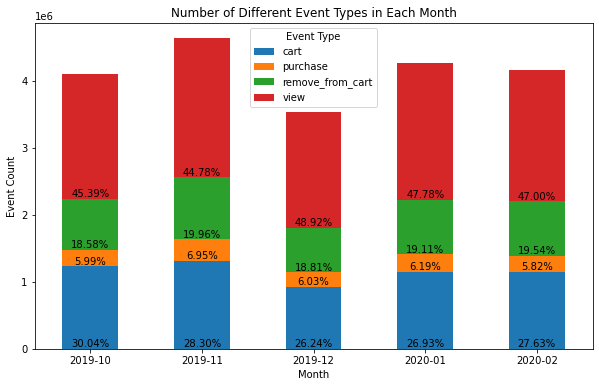

In [200]:
# Group by month and event_type and count occurrences
monthly_event_counts = target_data.groupby(['month', 'event_type']).size().unstack(fill_value=0)

# Calculate percentages
monthly_event_percentages = monthly_event_counts.div(monthly_event_counts.sum(axis=1), axis=0) * 100

# Plot the counts for each event_type by month with percentages
monthly_event_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Different Event Types in Each Month')
plt.xlabel('Month')
plt.ylabel('Event Count')
plt.xticks(rotation=0)
plt.legend(title='Event Type')

# Add percentages on top of each bar
for i in range(len(monthly_event_counts)):
    for j in range(len(monthly_event_counts.columns)):
        plt.text(i, monthly_event_counts.iloc[i, :j].sum() + monthly_event_percentages.iloc[i, j] / 2, 
                 f"{monthly_event_percentages.iloc[i, j]:.2f}%", 
                 ha='center', va='bottom')

plt.show()

In [205]:
# Calculate the total number of add-to-cart events
total_add_to_cart = (target_data['event_type'] == 'cart').sum()

# Calculate the total number of purchases
total_purchases = (target_data['event_type'] == 'purchase').sum()

# Calculate the add-to-cart conversion rate
add_to_cart_conversion_rate = total_purchases / total_add_to_cart

print(f"Add-to-Cart Conversion Rate: {add_to_cart_conversion_rate:.2%}")

Add-to-Cart Conversion Rate: 22.31%


### Analysis On Purchase Only

In [97]:
#Filter purchase-only events
purchase_data = target_data[target_data['event_type'] == 'purchase']

In [98]:
purchase_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287007 entries, 202 to 4156566
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   event_time  1287007 non-null  datetime64[ns]
 1   event_type  1287007 non-null  object        
 2   price       1287007 non-null  float64       
 3   user_id     1287007 non-null  int64         
 4   month       1287007 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), period[M](1)
memory usage: 58.9+ MB


In [99]:
purchase_data.head(3)

,event_time,event_type,price,user_id,month
202,2019-10-01 00:06:35,purchase,5.32,474232307,2019-10
204,2019-10-01 00:06:35,purchase,2.86,474232307,2019-10
205,2019-10-01 00:06:35,purchase,2.38,474232307,2019-10


### Monthly Trends

In [100]:
# Group by month and count the rows
monthly_row_counts = purchase_data.groupby('month').size()

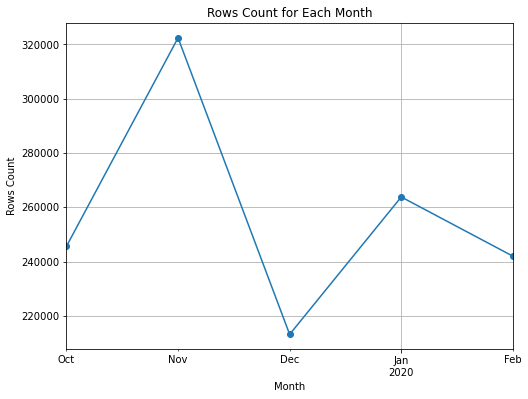

In [115]:
# Plot the rows count for each month
plt.figure(figsize=(8, 6))
monthly_row_counts.plot(marker='o')
plt.title('Rows Count for Each Month')
plt.xlabel('Month')
plt.ylabel('Rows Count')
plt.grid(True)

# # Add numbers on the plot
# for i, count in enumerate(monthly_row_counts):
#     plt.text(i, count/1000000, str(count)+'M', ha='center', va='bottom')

plt.show()

In [66]:
# Group by month and user_id, calculate user count, revenue, and average spent
monthly_purchase_stats = purchase_data.groupby(['month', 'user_id']).agg(
    user_count=('user_id', 'count'),
    revenue=('price', 'sum'),
    avg_spent=('price', 'mean')
).reset_index()

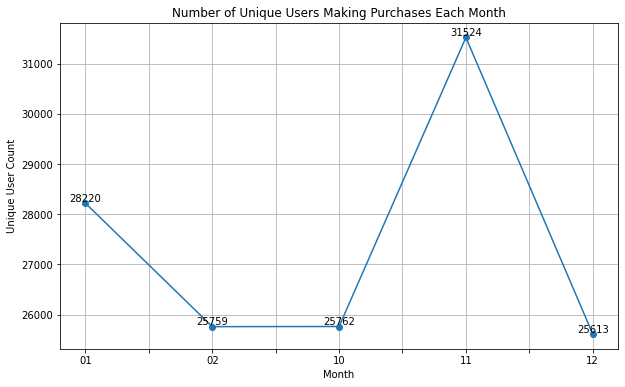

In [67]:
# Plot user count by month
plt.figure(figsize=(10, 6))
user_count = monthly_purchase_stats.groupby('month')['user_id'].count()
user_count.plot(marker='o')
plt.title('Number of Unique Users Making Purchases Each Month')
plt.xlabel('Month')
plt.ylabel('Unique User Count')
plt.grid(True)

# Add numbers on the plot
for i, count in enumerate(user_count):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

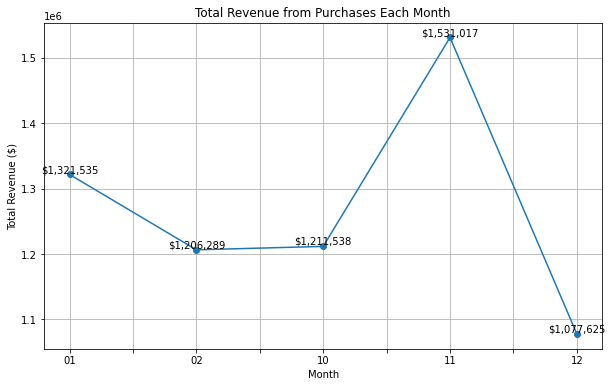

In [62]:
# Plot revenue by month
plt.figure(figsize=(10, 6))
revenue = monthly_purchase_stats.groupby('month')['revenue'].sum()
revenue.plot(marker='o')
plt.title('Total Revenue from Purchases Each Month')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.grid(True)

# Add numbers on the plot
for i, rev in enumerate(revenue):
    plt.text(i, rev, '${:,.0f}'.format(rev), ha='center', va='bottom')

plt.show()

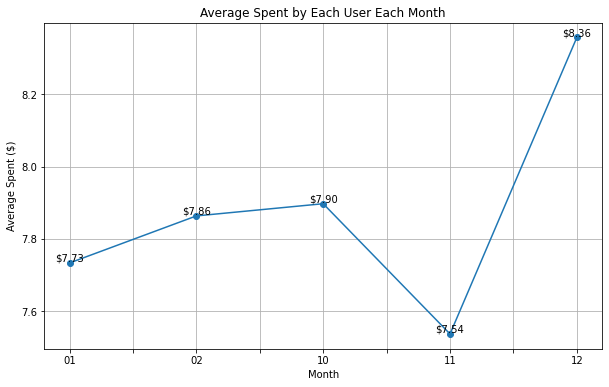

In [85]:
# Plot average spent by user each month
plt.figure(figsize=(10, 6))
avg_spent = monthly_purchase_stats.groupby('month')['avg_spent'].mean()
avg_spent.plot(marker='o')
plt.title('Average Spent by Each User Each Month')
plt.xlabel('Month')
plt.ylabel('Average Spent ($)')
plt.grid(True)

# Add numbers on the plot
for i, avg in enumerate(avg_spent):
    plt.text(i, avg, '${:,.2f}'.format(avg), ha='center', va='bottom')

plt.show()

### Weekly Trends

In [123]:
# Extract week from event_time
purchase_data['week'] = purchase_data['event_time'].dt.to_period('W')

<ipython-input-123-5f88a628ea04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_data['week'] = purchase_data['event_time'].dt.to_period('W')


In [73]:
# Group by week and count the rows
weekly_row_counts = purchase_data.groupby('week').size()

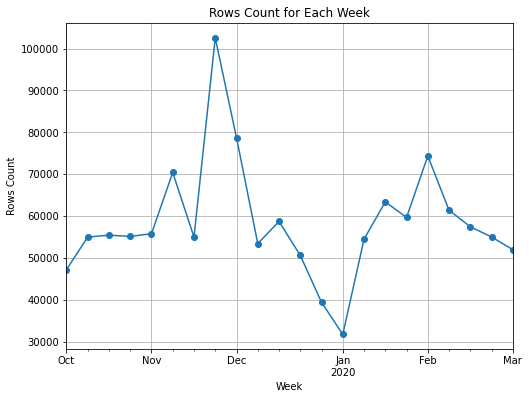

In [121]:
# Plot the rows count for each week
plt.figure(figsize=(8, 6))
weekly_row_counts.plot(marker='o')
plt.title('Rows Count for Each Week')
plt.xlabel('Week')
plt.ylabel('Rows Count')
plt.grid(True)

plt.show()

In [124]:
# Group by month and user_id, calculate user count, revenue, and average spent
weekly_purchase_stats = purchase_data.groupby(['week', 'user_id']).agg(
    user_count=('user_id', 'count'),
    revenue=('price', 'sum'),
    avg_spent=('price', 'mean')
).reset_index()

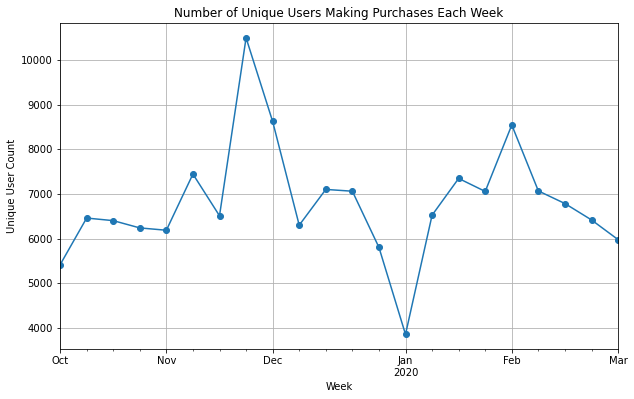

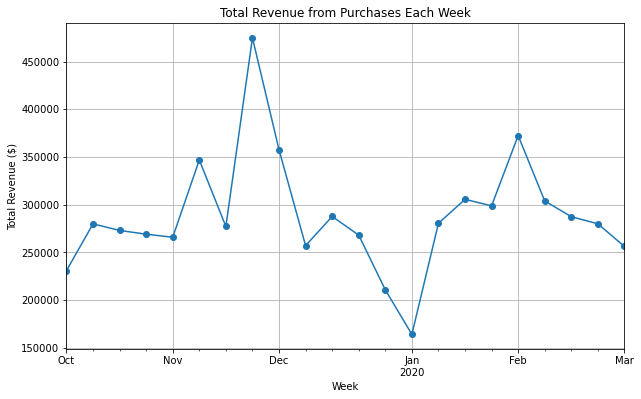

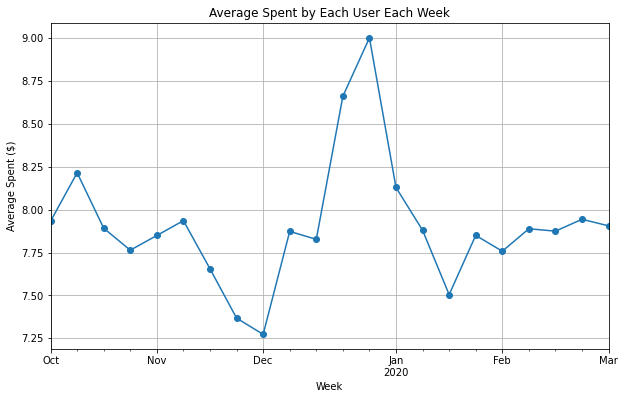

In [130]:
# Plot user count by week
plt.figure(figsize=(10, 6))
user_count = weekly_purchase_stats.groupby('week')['user_id'].count()
user_count.plot(marker='o')
plt.title('Number of Unique Users Making Purchases Each Week')
plt.xlabel('Week')
plt.ylabel('Unique User Count')
plt.grid(True)

plt.show()

# Plot revenue by week
plt.figure(figsize=(10, 6))
revenue = weekly_purchase_stats.groupby('week')['revenue'].sum()
revenue.plot(marker='o')
plt.title('Total Revenue from Purchases Each Week')
plt.xlabel('Week')
plt.ylabel('Total Revenue ($)')
plt.grid(True)

plt.show()

# Plot average spent by user each week
plt.figure(figsize=(10, 6))
avg_spent = weekly_purchase_stats.groupby('week')['avg_spent'].mean()
avg_spent.plot(marker='o')
plt.title('Average Spent by Each User Each Week')
plt.xlabel('Week')
plt.ylabel('Average Spent ($)')
plt.grid(True)

plt.show()

## RFM Analysis

In [132]:
target_data['event_time'].max()

Timestamp('2020-02-29 23:59:59')

In [133]:
# Group by user_id and calculate RFM metrics
rfm_data = purchase_data.groupby('user_id').agg(
    recency=('event_time', lambda x: (pd.to_datetime('2020-03-01') - x.max()).days),
    frequency=('event_time', 'count'),
    monetary=('price', 'sum')
)

In [136]:
rfm_data.head(3)

,recency,frequency,monetary
user_id,,,
9794320,96,4,12.68
10079204,115,2,25.81
10280338,10,86,177.83


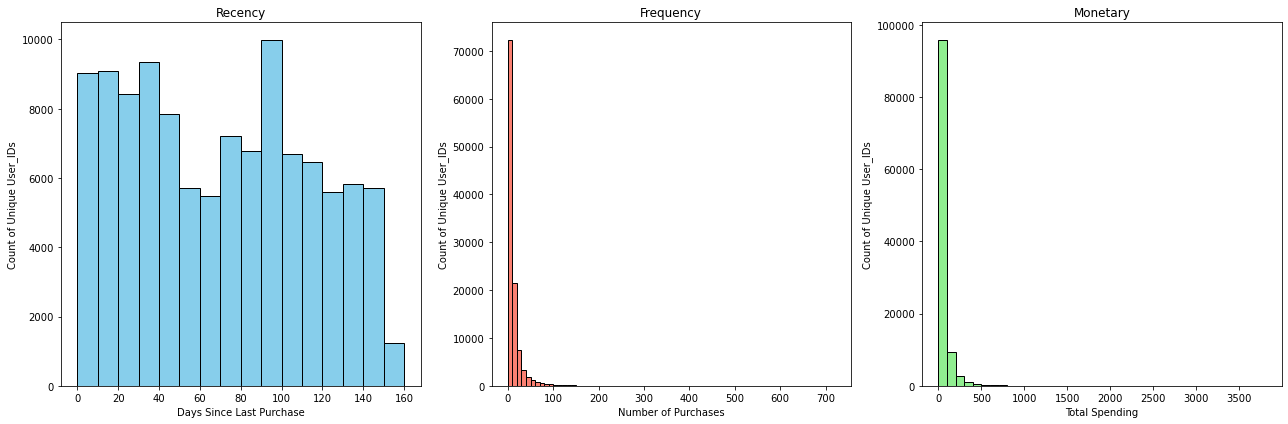

In [143]:
# Create subplots for each RFM metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Recency
recency_bins = range(0, rfm_data['recency'].max() + 10, 10)
axes[0].hist(rfm_data['recency'], bins=recency_bins, color='skyblue', edgecolor='black')
axes[0].set_title('Recency')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Count of Unique User_IDs')

# Plot Frequency
frequency_bins = range(0, rfm_data['frequency'].max() + 10, 10)
axes[1].hist(rfm_data['frequency'], bins=frequency_bins, color='salmon', edgecolor='black')
axes[1].set_title('Frequency')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Count of Unique User_IDs')

# Plot Monetary
monetary_bins = range(0, int(rfm_data['monetary'].max()) + 100, 100)
axes[2].hist(rfm_data['monetary'], bins=monetary_bins, color='lightgreen', edgecolor='black')
axes[2].set_title('Monetary')
axes[2].set_xlabel('Total Spending')
axes[2].set_ylabel('Count of Unique User_IDs')

plt.tight_layout()
plt.show()

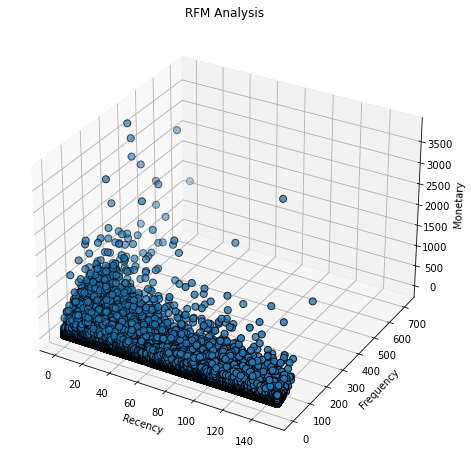

In [137]:
# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each user as a dot in the 3D space
ax.scatter(rfm_data['recency'], rfm_data['frequency'], rfm_data['monetary'], s=50, edgecolors='k')

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Analysis')

plt.show()

### RFM Without Outliers

In [166]:
# Calculate z-scores for each RFM metric
rfm_data['recency_zscore'] = (rfm_data['recency'] - rfm_data['recency'].mean()) / rfm_data['recency'].std()
rfm_data['frequency_zscore'] = (rfm_data['frequency'] - rfm_data['frequency'].mean()) / rfm_data['frequency'].std()
rfm_data['monetary_zscore'] = (rfm_data['monetary'] - rfm_data['monetary'].mean()) / rfm_data['monetary'].std()

# Filter out data points beyond two standard deviations for each metric
rfm_data_filtered = rfm_data[
    (rfm_data['recency_zscore'].abs() <= 2) &
    (rfm_data['frequency_zscore'].abs() <= 2) &
    (rfm_data['monetary_zscore'].abs() <= 2)
]

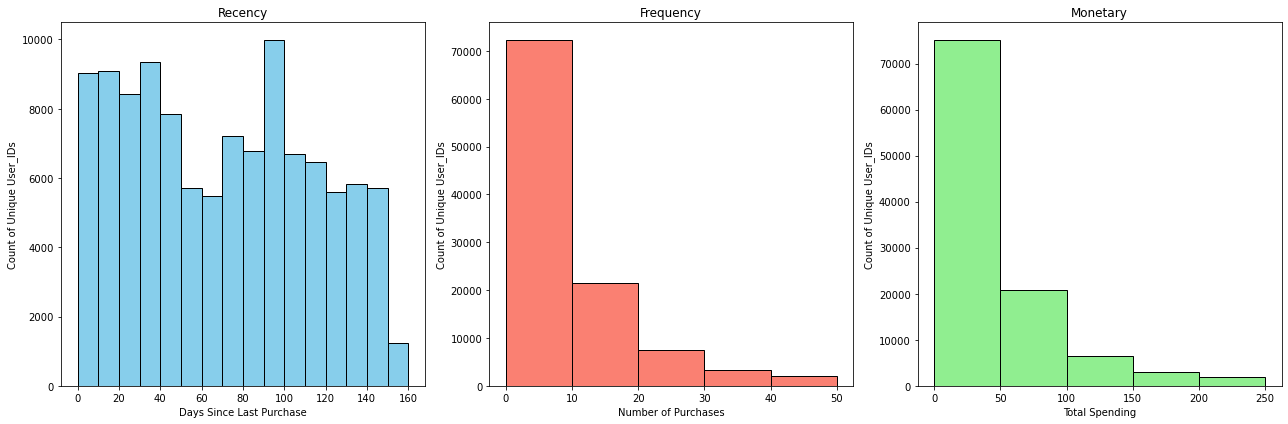

In [158]:
# Create subplots for each RFM metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Recency
recency_bins = range(0, rfm_data_filtered['recency'].max() + 10, 10)
axes[0].hist(rfm_data['recency'], bins=recency_bins, color='skyblue', edgecolor='black')
axes[0].set_title('Recency')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Count of Unique User_IDs')

# Plot Frequency
frequency_bins = range(0, rfm_data_filtered['frequency'].max() + 10, 10)
axes[1].hist(rfm_data['frequency'], bins=frequency_bins, color='salmon', edgecolor='black')
axes[1].set_title('Frequency')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Count of Unique User_IDs')

# Plot Monetary
monetary_bins = range(0, int(rfm_data_filtered['monetary'].max()) + 50, 50)
axes[2].hist(rfm_data['monetary'], bins=monetary_bins, color='lightgreen', edgecolor='black')
axes[2].set_title('Monetary')
axes[2].set_xlabel('Total Spending')
axes[2].set_ylabel('Count of Unique User_IDs')

plt.tight_layout()
plt.show()

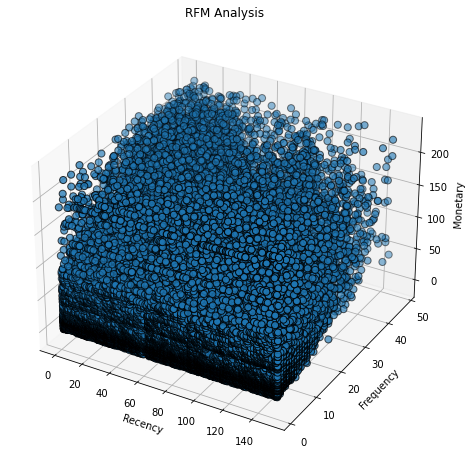

In [159]:
# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each user as a dot in the 3D space
ax.scatter(rfm_data_filtered['recency'], rfm_data_filtered['frequency'], 
           rfm_data_filtered['monetary'], s=50, edgecolors='k')

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Analysis')

plt.show()

## K-Means Clustering

In [191]:
# Filter out data points beyond two standard deviations for each metric
rfm_data_filtered_KM = rfm_data[
    (rfm_data['recency_zscore'].abs() <= 2) &
    (rfm_data['frequency_zscore'].abs() <= 2) &
    (rfm_data['monetary_zscore'].abs() <= 2)
]

In [192]:
rfm_data_filtered_KM = rfm_data_filtered_KM.drop(columns=['recency_zscore', 'frequency_zscore', 'monetary_zscore'])

### Elobow Method

In [193]:
# Standardize the data
rfm_standardized = (rfm_data_filtered_KM - rfm_data_filtered_KM.mean()) / rfm_data_filtered_KM.std()

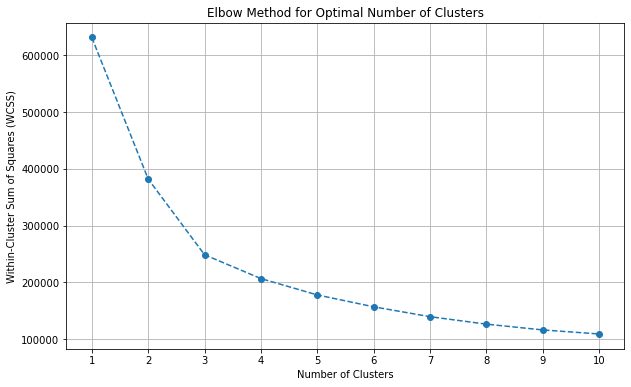

In [183]:
# Initialize a list to store within-cluster sum of squares (WCSS) for different number of clusters
wcss = []

# Try different numbers of clusters from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_standardized)
    # Append the WCSS for current number of clusters to the list
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [188]:
rfm_data_filtered_KM.head(3)

,recency,frequency,monetary,cluster
user_id,,,,
9794320,96,4,12.68,0
10079204,115,2,25.81,0
12055855,71,4,16.54,2


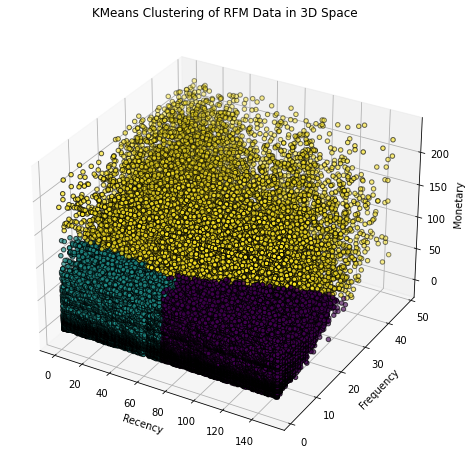

In [195]:
# Initialize KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit KMeans to the standardized RFM data
kmeans.fit(rfm_standardized)

# Add cluster labels to the original RFM data
rfm_data_filtered_KM['cluster'] = kmeans.labels_

# Visualize the clusters in 3D space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of Recency vs. Frequency vs. Monetary
ax.scatter(rfm_data_filtered_KM['recency'], 
           rfm_data_filtered_KM['frequency'], 
           rfm_data_filtered_KM['monetary'], c=rfm_data_filtered_KM['cluster'], cmap='viridis', edgecolor='k')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('KMeans Clustering of RFM Data in 3D Space')

plt.show()

## 80-20 Split

In [203]:
rfm_data_filtered.head(15)

,recency,frequency,monetary,recency_zscore,frequency_zscore,monetary_zscore,recency_top20,frequency_top20,monetary_top20,group
user_id,,,,,,,,,,
9794320,96,4,12.68,0.598319,-0.418561,-0.505001,0,0,0,0
10079204,115,2,25.81,1.030952,-0.528056,-0.356859,0,0,0,0
12055855,71,4,16.54,0.029064,-0.418561,-0.461450,0,0,0,0
12936739,43,2,29.89,-0.608500,-0.528056,-0.310825,0,0,0,0
15400971,78,3,35.71,0.188456,-0.473309,-0.245159,0,0,0,0
15781728,105,2,20.31,0.803250,-0.528056,-0.418914,0,0,0,0
19762782,111,8,80.29,0.939871,-0.199569,0.257826,0,0,1,1
20554973,45,7,21.81,-0.562960,-0.254317,-0.401990,0,0,0,0
23633626,32,8,22.13,-0.858972,-0.199569,-0.398379,0,0,0,0


In [168]:
# Calculate the 20th percentile for each RFM metric
recency_20th = np.percentile(rfm_data_filtered['recency'], 20)
frequency_20th = np.percentile(rfm_data_filtered['frequency'], 80)
monetary_20th = np.percentile(rfm_data_filtered['monetary'], 80)

In [169]:
# Mark users as 'top 20' if their RFM value exceeds the respective 20th percentile
rfm_data_filtered['recency_top20'] = np.where(rfm_data_filtered['recency'] <= recency_20th, 1, 0)
rfm_data_filtered['frequency_top20'] = np.where(rfm_data_filtered['frequency'] >= frequency_20th, 1, 0)
rfm_data_filtered['monetary_top20'] = np.where(rfm_data_filtered['monetary'] >= monetary_20th, 1, 0)

# Assign group numbers based on the combination of top 20 marks
rfm_data_filtered['group'] = rfm_data_filtered['recency_top20'] * 4 + rfm_data_filtered['frequency_top20'] * 2 + rfm_data_filtered['monetary_top20']

<ipython-input-169-211d1c5ac23c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_data_filtered['recency_top20'] = np.where(rfm_data_filtered['recency'] <= recency_20th, 1, 0)
<ipython-input-169-211d1c5ac23c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_data_filtered['frequency_top20'] = np.where(rfm_data_filtered['frequency'] >= frequency_20th, 1, 0)
<ipython-input-169-211d1c5ac23c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

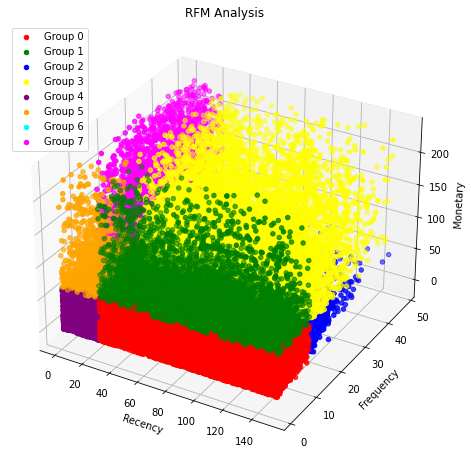

In [170]:
# Define colors for each group
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta']

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with a different color
for group, color in zip(range(8), colors):
    group_data = rfm_data_filtered[rfm_data_filtered['group'] == group]
    ax.scatter(group_data['recency'], group_data['frequency'], group_data['monetary'], c=color, label=f'Group {group}')

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Analysis')

plt.legend()
plt.show()

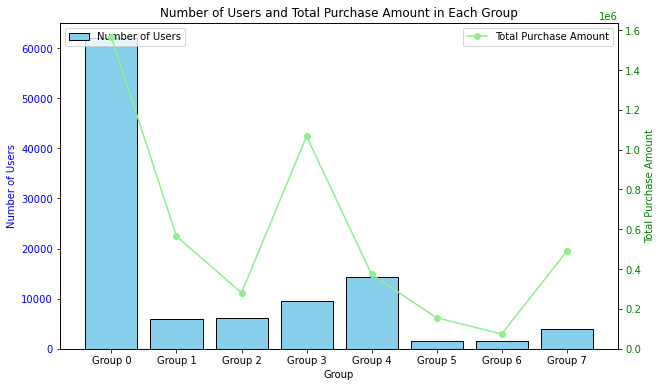

In [178]:
# Calculate total purchase amount in each group
group_purchase_amount = rfm_data_filtered.groupby('group')['monetary'].sum()
# Count the number of users in each group
group_counts = rfm_data_filtered['group'].value_counts().sort_index()

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the number of users on ax1
ax1.bar(group_counts.index, group_counts.values, color='skyblue', edgecolor='black')
ax1.set_xlabel('Group')
ax1.set_ylabel('Number of Users', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create another y-axis for the total purchase amount
ax2 = ax1.twinx()
ax2.plot(group_purchase_amount.index, group_purchase_amount.values, color='lightgreen', marker='o')
ax2.set_ylabel('Total Purchase Amount', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Set x-axis ticks and labels
plt.xticks(range(8), ['Group 0', 'Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7'])

# Add legend
ax1.legend(['Number of Users'], loc='upper left')
ax2.legend(['Total Purchase Amount'], loc='upper right')

# Title
plt.title('Number of Users and Total Purchase Amount in Each Group')

plt.show()